#### 5.2 합성곱 신경망 맛보기
- fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현해보자
    * 열 가지로 분류될 수 있는 28 x 28 픽셀의 이미지 7만개로 구성.

>>> 라벨 분류
- 0 : T-Shirt
- 1 : Trouser
- 2 : Pullover
- 3 : Dress
- 4 : Coat
- 5 : Sandal
- 6 : Shirt
- 7 : Sneaker
- 8 : Bag
- 9 : Ankle Boot

[1] 모듈 로딩

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# CPU 혹은 GPU 장치 확인
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

[2] 데이터 준비

In [3]:
train_dataset=torchvision.datasets.FashionMNIST('../data', download=True,
                                                 transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=torchvision.datasets.FashionMNIST('../data', download=True, train=False,
                                                 transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [4]:
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=100)

[3] 라벨 클래스 정의

In [5]:
labels_map={0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
           5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

[4] 이미지 데이터 확인(20개)

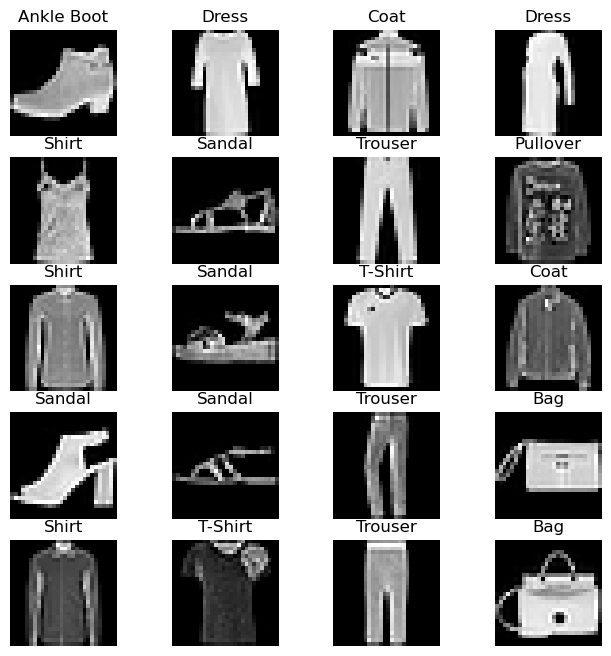

In [6]:
fig=plt.figure(figsize=(8,8))
columns=4
rows=5
for i in range(1, columns*rows + 1):
    img_xy=np.random.randint(len(train_dataset))
    img=train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

[5] 학습 준비<hr>
[5-1] DNN 모델

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1=nn.Linear(in_features=784, out_features=256)
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=256, out_features=128)
        self.fc3=nn.Linear(in_features=128, out_features=10)
    
    def forward(self, input_data):
        out=input_data.view(-1, 784)
        out=F.relu(self.fc1(out))
        out=self.drop(out)
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out

[5-2] 파라미터 정의(DNN 모델)

In [8]:
learning_rate=0.001
model=FashionDNN().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


[6] 학습 및 결과 확인(DNN 모델)

In [9]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100, 1, 28, 28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100, 1, 28, 28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)
            
            accuracy=correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5887407064437866, Accuracy: 83.06999969482422%
Iteration: 1000, Loss: 0.5084725022315979, Accuracy: 84.41000366210938%
Iteration: 1500, Loss: 0.36464840173721313, Accuracy: 84.77999877929688%
Iteration: 2000, Loss: 0.3120841383934021, Accuracy: 85.73999786376953%
Iteration: 2500, Loss: 0.2883942425251007, Accuracy: 85.7300033569336%
Iteration: 3000, Loss: 0.3391992449760437, Accuracy: 86.56999969482422%


- 최종 정확도 약 86%

[7] 학습 준비<hr>
[7-1] CNN 모델

In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0), -1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out

[7-2] 파라미터 정의(CNN 모델)

In [11]:
learning_rate=0.001
model=FashionCNN().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


[8] 학습 및 결과 확인(CNN 모델)

In [12]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)

        train=Variable(images.view(100, 1, 28, 28))
        labels=Variable(labels)

        outputs=model(train)
        loss=criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total=0
            correct=0
            for images, labels in test_loader:
                images, labels=images.to(device), labels.to(device)
                labels_list.append(labels)
                test=Variable(images.view(100, 1, 28, 28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions==labels).sum()
                total += len(labels)
            
            accuracy=correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4340232014656067, Accuracy: 87.55999755859375%
Iteration: 1000, Loss: 0.33471351861953735, Accuracy: 87.72000122070312%
Iteration: 1500, Loss: 0.28989091515541077, Accuracy: 89.25%
Iteration: 2000, Loss: 0.18877123296260834, Accuracy: 89.36000061035156%
Iteration: 2500, Loss: 0.1560244858264923, Accuracy: 89.22000122070312%
Iteration: 3000, Loss: 0.1598515659570694, Accuracy: 90.33999633789062%


- CNN 모델 학습 결과 최종 정확도 약 90% => 앞선 DNN 모델보다 4% 가량 더 높다